# Project 2: Modelling Road Deformation using Non-Linear Least-Squares

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Weeks 3 & 4, Friday Sep 20 & Friday Sep 27, 2024.*

# Background

There are numerous subsurface processes that give rise to observable subsidence at the surface. These processes can be categorized into two main categories: 'deep' subsidence and 'shallow' subsidence. 'Deep' subsidence stems from processes occurring in the deeper subsurface layers (e.g., deeper than 0.5 kilometers below the surface). For instance, extracting gas from a reservoir leads to compaction of the deeper layers, which then results in subsidence of the Earth's surface. On the other hand, 'shallow' subsidence arises from activities within the upper layers of the subsurface. When the groundwater table drops, it triggers shrinkage and oxidation of organic material above the ground water level. Additionally, processes like consolidation and creep contribute to shallow subsidence. Conversely, when the groundwater level rises, a portion of the subsidence becomes reversible, as the layers swell due to the increased water content.

In the Green Heart region in the Netherlands a lot of 'shallow' subsidence occurs. In the typical polder landscape the groundwater table is kept blow a certain level, causing peat layers to oxidize and shrink resulting in subsidence. Also, since the ground water level is highly variable over the year (due to changes in temperature and precipitation), this results in highly variable ground movements which can be quite significant. 

In the context of our assignment, we investigate the observed deformation of a recently constructed road in the <a href="https://www.groenehart.nl/the-green-heart-of-holland" target="_blank"> Green Heart</a> Region. It's reasonable to anticipate that when a heavy structure is built on top of a 'soft' soil layer, additional subsidence may occur due to compaction in the upper surface layers. Over time, as the sediment settles, this extra compaction will diminish. However, it is still expected to observe some up and down movement related due to changing ground water levels. 

### Data

The input data for this assignment are two different deformation time series for a (hypothetical) road in the Green heart in the Netherlands. We assume that the road was built in 2016. We will have a look at <a href="https://en.wikipedia.org/wiki/Interferometric_synthetic-aperture_radar" target="_blank"> InSAR</a> (Interferometric Synthetic Aperture Radar) data and <a href="https://en.wikipedia.org/wiki/Satellite_navigation" target="_blank"> GNSS</a> (Global Navigation Satellite System) data.

With InSAR we can retrieve displacements from time series of radar images. In this exercise we will consider displacement time series from Sentinel-1 from 2017 till 2019. More information on the Sentinel-1 mission can be found <a href="https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-1" target="_blank">here</a>.

In the project repository on GitLab, you will find three data files for this assignment:
- `gnss_observations.csv`
- `insar_observations.csv`
- `groundwter_levels.csv`. 

Note that all files consist of two columns, one for the dates and one for the observations. 

In the GNSS and InSAR files the observations are observed vertical displacements (units of m).

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>Note that ground water levels are in units of mm.</p></div>

In [1]:
import numpy as np
import scipy as sc
from scipy import interpolate

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from scipy.stats.distributions import chi2
from scipy.stats import norm

np.set_printoptions(precision=3)

## Task 1: Preparing the data

Within this assignment you will work with two types of data: InSAR data and GNSS data. The cell below will load the data and visualize the observed displacements time. In this task we use the package `pandas`, which is really useful for handling time series. We will learn how to use it later in the quarter; for now, you only need to recognize that it imports the data as a `dataframe` object, which we then convert into a numpy array using the code below.

In [2]:
gnss = pd.read_csv('./data/gnss_observations.csv')
dates_gnss = pd.to_datetime(gnss['dates'])
gnss_obs = (gnss['observations[m]']).to_numpy()*1000

insar = pd.read_csv('./data/insar_observations.csv')
dates_insar = pd.to_datetime(insar['dates'])
insar_obs = (insar['observations[m]']).to_numpy()*1000

gw = pd.read_csv('./data/groundwater_levels.csv')
dates_gw = pd.to_datetime(gw['dates'])
gw_obs = (gw['observations[mm]']).to_numpy()

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>Note that we convert all observations to millimeters here.</p></div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1:</b>   
    
Once you have used the cell above to import the data, investigate the data sets using the code cell below. Then provide some relevant summary information in the Markdown cell. Hint: use some of the techniques we covered in the Programming Assignments.
    
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>The code below gives some examples of the quantitative and qualitative ways you could have looked at the data. It is more than you were expected to do; the important thing is that you showed the ability to learn something about the data and describe aspects that are relevant to our problem. We use a dictionary to easily access the different data series using their names, which are entered as the dictionary keys (also not expected of you, but it's hopefully fun to learn useful tricks).</div>

In [3]:
data_list = ['gnss_obs', 'insar_obs', 'gw_obs']
data_dict = {data_list[0]: gnss_obs,
             data_list[1]: insar_obs,
             data_list[2]: gw_obs}
def print_summary(data):
    '''Summarize an array with simple print statements.'''
    print('Minimum =     ', data.min())
    print('Maximum =     ', data.max())
    print('Mean =        ', data.mean())
    print('Std dev =     ', data.std())
    print('Shape =       ', data.shape)
    print('First value = ', data[0])
    print('Last value =  ', data[-1])
    print('\n')
          
for item in data_list:
    print('Summary for array: ', item)
    print('------------------------------------------------')
    print_summary(data_dict[item])

Summary for array:  gnss_obs
------------------------------------------------
Minimum =      -77.85967600765021
Maximum =      29.432302555465
Mean =         -26.998775875445148
Std dev =      16.2218064476615
Shape =        (730,)
First value =  -13.980633493923001
Last value =   -38.6733705713608


Summary for array:  insar_obs
------------------------------------------------
Minimum =      -37.339155096180406
Maximum =      -3.7915269917409
Mean =         -25.459757789872686
Std dev =      6.8998022892131585
Shape =        (61,)
First value =  -3.7915269917409
Last value =   -30.2754656176263


Summary for array:  gw_obs
------------------------------------------------
Minimum =      -166.784
Maximum =      -102.044
Mean =         -127.70472
Std dev =      16.822297827633417
Shape =        (25,)
First value =  -109.698
Last value =   -117.268




In [4]:
print('Dates are type: ', type(dates_insar))

Dates are type:  <class 'pandas.core.series.Series'>


<Figure size 1500x400 with 0 Axes>

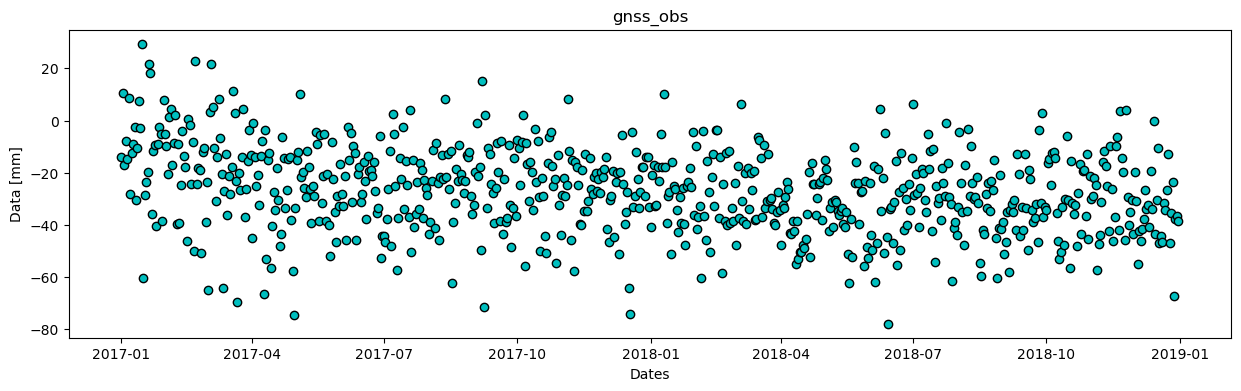

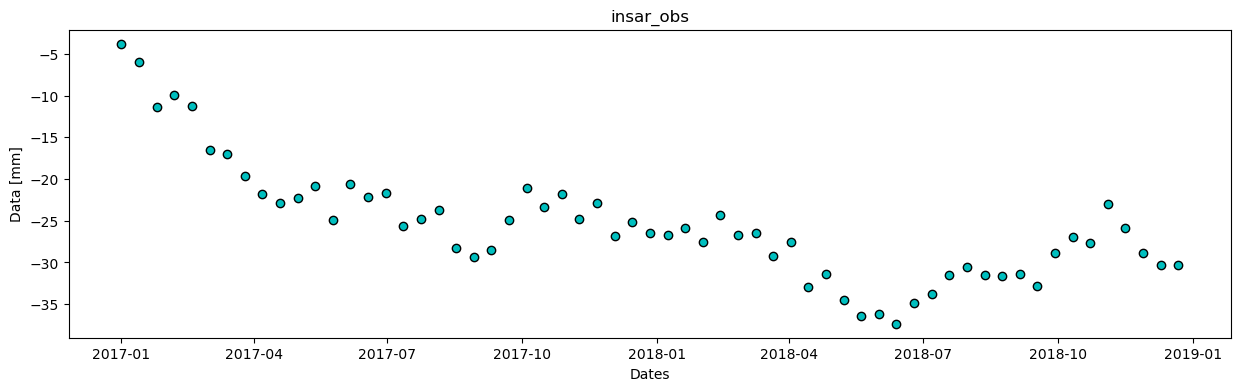

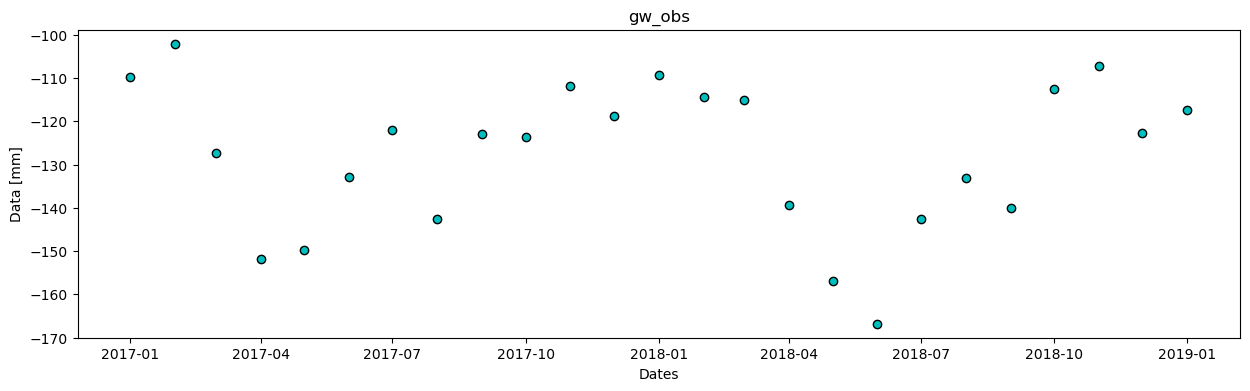

In [5]:
dates_dict = {data_list[0]: dates_gnss,
              data_list[1]: dates_insar,
              data_list[2]: dates_gw}
def plot_data(dates, data, label):
    plt.figure(figsize=(15,4))
    plt.plot(dates, data, 'co', mec='black')
    plt.title(label)
    plt.xlabel('Dates')
    plt.ylabel('Data [mm]')
    plt.show()

plt.figure(figsize=(15,4))
for i in range(3):
    plot_data(dates_dict[data_list[i]],
              data_dict[data_list[i]],
              data_list[i])

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>   
    
There are a lot more GNSS data points than InSAR or groundwater. The GNSS observations also have more noise, and what seem to be outliers. In this case the mean and standard deviation do not mean much, because there is clearly a trend with time. We can at least confirm that the time periods of measurements overlap, although the intervals between measurements is certainly not uniform (note that you don't need to do anything with the dates, since they are pandas time series and we have not covered them yet).
</p>
</div>

You may have noticed that the groundwater data is available for different dates/times than the GNSS and InSAR data. You will therefore have to *interpolate* the data to the same dates/times for a further analysis. You can use the SciPy function ```interpolate.interp1d``` (read its [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)).

The cells below do the following:
1. Define a function to convert the time unit
2. Convert the time stamps for all data
3. Use `interp1d` to interpolate the groundwater measurements at the time of the satellite measurements

In [6]:
def to_days_years(dates):
    '''Convert the observation dates to days and years.'''
    
    dates_datetime = pd.to_datetime(dates)
    time_diff = (dates_datetime - dates_datetime[0])
    days_diff = (time_diff / np.timedelta64(1,'D')).astype(int)
    
    days = days_diff.to_numpy()
    years = days/365
    
    return days, years

In [7]:
days_gnss,  years_gnss  = to_days_years(dates_gnss)
days_insar, years_insar = to_days_years(dates_insar)
days_gw,    years_gw    = to_days_years(dates_gw)

interp = interpolate.interp1d(days_gw, gw_obs)

GW_at_GNSS_times = interp(days_gnss)
GW_at_InSAR_times = interp(days_insar)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2:</b>   
    
Answer/complete the code and Markdown cells below:
<ol>
    <li>What is <code>interp</code>? (what kind of object is it, and how does it work?)</li>
    <li>How did the groundwater observation array change? Be quantitative. </li>
</ol>

2024: instead of printing as below, we can ask them to plot the GW original, and at GNSS and InSAR times and let them explain in report why they had to interpolate, and how interpolation works.
    
</p>
</div>

In [8]:
print('array size of GW_at_GNSS_times', len(GW_at_GNSS_times))
print('array size of GW_at_InSAR_times', len(GW_at_InSAR_times))
print('array size of GW before interpolation', len(gw_obs))

print(dates_gw[0:2])
print(gw_obs[0:2])
print(dates_gnss[0:2])
print(GW_at_GNSS_times[0:2])

array size of GW_at_GNSS_times 730
array size of GW_at_InSAR_times 61
array size of GW before interpolation 25
0   2017-01-01
1   2017-02-01
Name: dates, dtype: datetime64[ns]
[-109.698 -102.044]
0   2017-01-01
1   2017-01-02
Name: dates, dtype: datetime64[ns]
[-109.698 -109.451]


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>
<ol>
    <li><code>interp</code> is a function that will return a value (gw level) for the input(s) (date(s)). The interpolated value is found by linearly interpolating between the two nearest dates in the gw observations.</li>
    <li>The observation arrays of <code>GW_at_GNSS_times</code> and <code>GW_at_INSAR_times</code> changed in size to match the size of the GNSS and InSAR observations, respectively.</li>
</ol>  
</p>
</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.3:</b>   
    
Create a single plot to compare observed displacement for the GNSS and InSAR data sets.
    
</p>
</div>

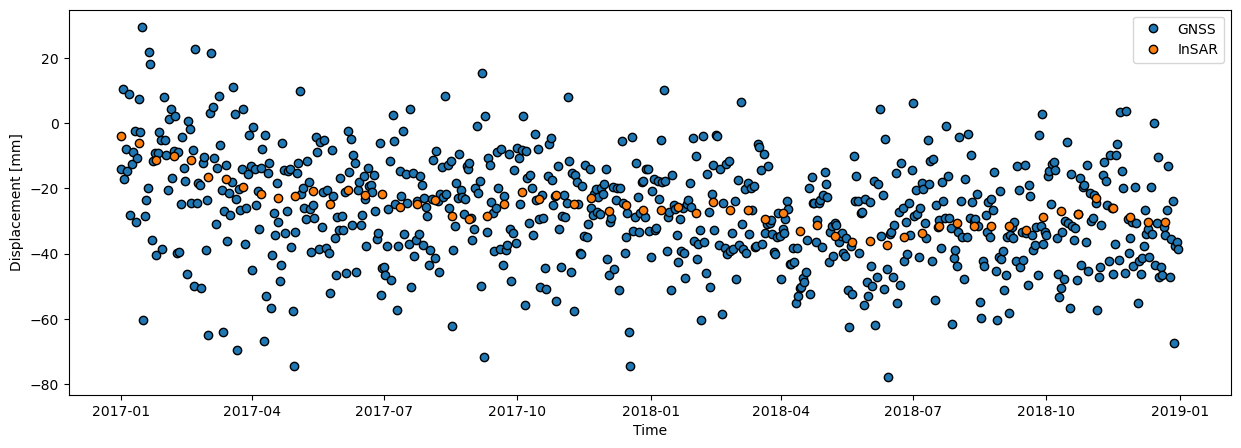

In [9]:
plt.figure(figsize=(15,5))
plt.plot(dates_gnss, gnss_obs, 'o', mec='black', label = 'GNSS')
plt.plot(dates_insar, insar_obs, 'o', mec='black', label = 'InSAR')
plt.legend()
plt.ylabel('Displacement [mm]')
plt.xlabel('Time')
plt.show()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.4:</b>   
What is your interpretation of the data? What kind of deformation do you see? And what are the differences between both datasets? Be quantitative.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>   
    
The points obviously show subsidence, the displacement shows a similar pattern for both datasets. The GNSS data is much noisier than InSAR (range is around 60 mm versus only a few mm), but has a higher sampling rate. Also there seem to be more outliers in the GNSS data compared to InSAR, especially at the start of the observation period. InSAR has only observations every 6 days but is less noisy. 
</p>
</div>

## Task 2: Set-up linear functional model

We want to investigate how we could model the observed displacements of the road. Because the road is built in the Green Heart we expect that the observed displacements are related to the groundwater level. Furthermore, we assume that the displacements can be modeled using a constant velocity. The model is defined as 
$$
d = d_0 + vt + k \ \textrm{GW},
$$
where $d$ is the displacement, $t$ is time and $\textrm{GW}$ is the groundwater level (that we assume to be deterministic). 

Therefore, the model has 3 unknowns:
1. $d_0$, as the initial displacement at $t_0$;
2. $v$, as the displacement velocity;
3. $k$, as the 'groundwater factor', which can be seen as the response of the soil to changes in the groundwater level.


As a group you will construct the **functional model** that is defined as 
$$
\mathbb{E}(Y) = \mathrm{A x}.
$$



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.1:</b>   
    
Construct the design matrix $A$ and the observation vector $Y$ (for both InSAR and GNSS observations), then show the first 5 observations.
</p>
</div>

In [10]:
# Contruct A and Y for InSAR: A_insar, y_insar
# YOUR_CODE_HERE

A_insar = np.ones((len(dates_insar), 3))
A_insar[:,1] = days_insar
A_insar[:,2] = GW_at_InSAR_times

print ('The first 5 rows of the A matrix (InSAR) are:')
print (A_insar[0:5, :])

y_insar = insar_obs
print ('The first 5 observations [mm] of y_insar are:')
print (y_insar[0:5])

m_insar = np.shape(A_insar)[0]
n_insar = np.shape(A_insar)[1]
print(f'm = {m_insar} and n = {n_insar}')

The first 5 rows of the A matrix (InSAR) are:
[[   1.       0.    -109.698]
 [   1.      12.    -106.735]
 [   1.      24.    -103.772]
 [   1.      36.    -106.536]
 [   1.      48.    -117.316]]
The first 5 observations [mm] of y_insar are:
[ -3.792  -5.999 -11.403  -9.92  -11.283]
m = 61 and n = 3


In [11]:
# Contruct A and Y for GNSS: A_gnss, y_gnss
# YOUR_CODE_HERE

A_gnss = np.ones((len(dates_gnss), 3))
A_gnss[:,1] = days_gnss
A_gnss[:,2] = GW_at_GNSS_times

print ('The first 5 rows of the A matrix (GNSS) are:')
print (A_gnss[0:5, :])

y_gnss = gnss_obs
print ('\nThe first 5 observations [mm] of y_gnss are:')
print (y_gnss[0:5])

m_gnss = np.shape(A_gnss)[0]
n_gnss = np.shape(A_gnss)[1]
print(f'm = {m_gnss} and n = {n_gnss}')

The first 5 rows of the A matrix (GNSS) are:
[[   1.       0.    -109.698]
 [   1.       1.    -109.451]
 [   1.       2.    -109.204]
 [   1.       3.    -108.957]
 [   1.       4.    -108.71 ]]

The first 5 observations [mm] of y_gnss are:
[-13.981  10.392 -17.091  -7.924 -14.729]
m = 730 and n = 3


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.2:</b>   
Answer the following questions:
<ol>
    <li>What is the dimension of the observables' vector $Y$?
    <li>What are the unknowns of the functional model?</li>
    <li>What is the redundancy for this model?</li>
</ol>
</p>
</div>


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>
    
For InSAR:
<ol>
    <li>The number of observations is 61.</li>
    <li>The number of unknowns is 3.</li>
    <li>The redundancy is 58.</li>
</ol>
    
For GNSS:
<ol>
    <li>The number of observations is 730.</li>
    <li>The number of unknowns is 3.</li>
    <li>The redundancy is 727.</li>
</ol>   
</p>
</div>

## 3. Set-up stochastic model

We will use the Best Linear Unbiased Estimator (BLUE) to solve for the unknown parameters. Therefore we also need a stochastic model, which is defined as
$$
\mathbb{D}(Y) = \Sigma_{Y}.
$$
where $\Sigma_{Y}$ is the covariance matrix of the observables' vector. 




<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1:</b>   
    
Construct the covariance matrix and assume that 

- the observables are independent

- the observables are normally distributed

- the observables' standard deviation is
    
    - $\sigma_\textrm{InSAR} = 2$ mm 
    - $\sigma_\textrm{GNSS} = 15$ mm 
    
</p>
</div>


In [12]:
# Stochastic model for InSAR: Sigma_Y_insar
# YOUR_CODE_HERE

std_insar = 2 #mm

Sigma_Y_insar = np.identity(len(dates_insar))*std_insar**2

print ('Sigma_Y (InSAR) is defined as:')
print (Sigma_Y_insar)

Sigma_Y (InSAR) is defined as:
[[4. 0. 0. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 4.]]


In [13]:
# Stochastic model for GNSS: Sigma_Y_gnss
# YOUR_CODE_HERE

std_gnss = 15 #mm (corrected from original value of 5 mm)

Sigma_Y_gnss = np.identity(len(dates_gnss))*std_gnss**2

print ('\nSigma_Y (GNSS) is defined as:')
print (Sigma_Y_gnss)


Sigma_Y (GNSS) is defined as:
[[225.   0.   0. ...   0.   0.   0.]
 [  0. 225.   0. ...   0.   0.   0.]
 [  0.   0. 225. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 225.   0.   0.]
 [  0.   0.   0. ...   0. 225.   0.]
 [  0.   0.   0. ...   0.   0. 225.]]


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.2:</b>   
Answer the following questions:
<ol>
    <li>What information is contained in the covariance matrix?</li>
    <li>How do you implement the assumption that all observations are independent?</li>
    <li>What is the dimension of $\Sigma_{Y}$?</li>
    <li>How do you create $\Sigma_{Y}$?</li>
</ol>
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 
<ol>
    <li>The covariance matrix contains information on the quality of the observations, where an entry on the diagonal represents the variance of one observation at a particular epoch. If there is an indication that for instance the quality for a particular time interval differs, different $\sigma$ values can be put in the stochastic model for these epochs. </li>
    <li>The off-diagonal terms in the matrix are related to the correlation between observations at different epochs, where a zero value on the off-diagonal indicates zero correlation.</li>
    <li>The dimension of the matrix is 61x61 for InSAR and 730x730 for GNSS.</li>
    <li>See code.</li>
</ol>    
</p>
</div>

## 4. Apply best linear unbiased estimation



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.1:</b>   
    
Write a function to apply BLUE in the cell below and use the function to estimate the unknowns for the model using the data. Print the values for the estimated parameters.

2024: add that the function should also output yhat, Sigma_yhat, ehat, Sigma_ehat
</p>
</div>



In [14]:
def BLUE(A, y, Sigma_Y):
    """Calculate the Best Linear Unbiased Estimator
    
    Write a docstring here (an explanation of your function).
    
    Function to calculate the Best Linear Unbiased Estimator
    
    Input:
        A = A matrix (mxn)
        y = vector with obervations (mx1)
        Sigma_Y = Varaiance covariance matrix of the observations (mxm)
    
    Output:
        xhat = vector with the estimates (nx1)
        Sigma_Xhat = variance-covariance matrix of the unknown parameters (nxn)
    """
    
    # YOUR_CODE_HERE
    
    Sigma_Xhat = np.linalg.inv(A.T @ np.linalg.inv(Sigma_Y) @ A)
    xhat = Sigma_Xhat @ A.T @ np.linalg.inv(Sigma_Y) @ y
    
    return xhat, Sigma_Xhat  

In [15]:
# Estimate the unknown parameters with InSAR: xhat_insar, Sigma_Xhat_insar
# YOUR_CODE_HERE

xhat_insar, Sigma_Xhat_insar = BLUE(A_insar, y_insar, Sigma_Y_insar)

print ('The InSAR-estimated offset is', np.round(xhat_insar[0],3), 'mm')
print ('The InSAR-estimated velocity is', np.round(xhat_insar[1],4), 'mm/day')
print ('The InSAR-estimated velocity is', np.round(xhat_insar[1]*365,4), 'mm/year')
print ('The InSAR-estimated GW factor is', np.round(xhat_insar[2],3), '[-]')


# Estimate the unknown parameters with GNSS: xhat_gnss, Sigma_Xhat_gnss
# YOUR_CODE_HERE

xhat_gnss, Sigma_Xhat_gnss = BLUE(A_gnss, y_gnss, Sigma_Y_gnss)

print ('The GNSS-estimated offset is', np.round(xhat_gnss[0],3), 'mm')
print ('The GNSS-estimated velocity is', np.round(xhat_gnss[1],4), 'mm/day')
print ('The GNSS-estimated velocity is', np.round(xhat_gnss[1]*365,4), 'mm/year')
print ('The GNSS-estimated GW factor is', np.round(xhat_gnss[2],3), '[-]')

The InSAR-estimated offset is 9.174 mm
The InSAR-estimated velocity is -0.0243 mm/day
The InSAR-estimated velocity is -8.8667 mm/year
The InSAR-estimated GW factor is 0.202 [-]
The GNSS-estimated offset is 1.181 mm
The GNSS-estimated velocity is -0.0209 mm/day
The GNSS-estimated velocity is -7.615 mm/year
The GNSS-estimated GW factor is 0.16 [-]


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.2:</b>   
Do the values that you just estimated make sense? Explain, using quantitative results.
</p>
</div>



<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>   
    
As long as the velocity is negative and around -0.02 mm/day or -10 mm/yr it makes sense if you compare with what you see in the plots with observations. Since load is applied on soil layers we expect the road to subside. We also expect to see a positive value for the GW factor.
    
</p>
</div>

## 5. Evaluate the precision



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5:</b>   
    
Answer
- What is the precision of the final estimates? 
    
Print the full covariance matrix of your estimates, and give an interpretation of the numbers in the covariance matrix.
</p>
</div>



In [16]:
# Precision of InSAR
print ('Covariance matrix of estimated parameters (InSAR):')
print (Sigma_Xhat_insar)
print ('\nThe standard deviation for the InSAR-estimated offset is', 
       np.round(np.sqrt(Sigma_Xhat_insar[0,0]),3), 'mm')
print ('The standard deviation for the InSAR-estimated velocity is', 
       np.round(np.sqrt(Sigma_Xhat_insar[1,1]),4), 'mm/day')
print ('The standard deviation for the InSAR-estimated GW factor is', 
       np.round(np.sqrt(Sigma_Xhat_insar[2,2]),3), '[-]\n')

# Precision of GNSS
print ('Covariance matrix of estimated parameters (GNSS):')
print (Sigma_Xhat_gnss)
print ('\nThe standard deviation for the GNSS-estimated offset is', 
       np.round(np.sqrt(Sigma_Xhat_gnss[0,0]),3), 'mm')
print ('The standard deviation for the GNSS-estimated velocity is', 
       np.round(np.sqrt(Sigma_Xhat_gnss[1,1]),4), 'mm/day')
print ('The standard deviation for the GNSS-estimated GW factor is', 
       np.round(np.sqrt(Sigma_Xhat_gnss[2,2]),3), '[-]')

Covariance matrix of estimated parameters (InSAR):
[[ 4.530e+00 -4.173e-04  3.363e-02]
 [-4.173e-04  1.472e-06  8.776e-07]
 [ 3.363e-02  8.776e-07  2.646e-04]]

The standard deviation for the InSAR-estimated offset is 2.128 mm
The standard deviation for the InSAR-estimated velocity is 0.0012 mm/day
The standard deviation for the InSAR-estimated GW factor is 0.016 [-]

Covariance matrix of estimated parameters (GNSS):
[[ 2.160e+01 -2.244e-03  1.595e-01]
 [-2.244e-03  6.945e-06  2.238e-06]
 [ 1.595e-01  2.238e-06  1.249e-03]]

The standard deviation for the GNSS-estimated offset is 4.647 mm
The standard deviation for the GNSS-estimated velocity is 0.0026 mm/day
The standard deviation for the GNSS-estimated GW factor is 0.035 [-]


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>
    
As shown above, the standard deviations of the estimated parameters are equal to the square root of the diagonal elements. Compared with the estimated values, the standard deviations seem quite small, except for the estimated offsets. Meaning that the complete estimated model can be shifted up or down. 
    
The off-diagonal elements show the covariances between the estimated parameters, which are non-zeros since the estimates are all computed as function of the same vector of observations and the same model. A different value for the estimated velocity would imply a different value for the GW factor and offset.  
    
</p>
</div>

## 6. Present and reflect on estimation results



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6.1:</b>   
    
Compute the modeled displacements ($\hat{\mathrm{y}}$), and corresponsing residuals ($\hat{\mathrm{\epsilon}}$). 
Visualize the results in two graphs and add the confidence bounds ($t$-versus-displacement and $t$-versus-residuals).

Also create a histogram of the residuals where you plot the normal distribution (which you can estimate from the histogram) as well and report the mean and sigma of the residuals. 

2024: with the additional outputs from BLUE function, computing of ehat and yhat not needed in code below.
And let's change the confidence level to 96%, which should in fact be an input variable to the function.
</p>
</div>


<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p><strong>Note</strong>: this Task 6.1 gives you a lot of freedom for how you can set up your figures. For example, you could write a function to create the plots, then use it twice, once for each dataset. This might also take a significant amount of time, so plan accordingly.</p></div>

In [17]:
def plot_residual(date, y_obs, yhat, data_type, A,
                  Sigma_Xhat, Sigma_Y, true_disp):

    ehat = y_obs - yhat

    # Compute the vc matrix for \hat{y}
    Sigma_Yhat = A @ Sigma_Xhat @ A.T
    std_y = np.sqrt(Sigma_Yhat.diagonal())

    # Compute the vc matrix for \hat{e}
    Sigma_ehat = Sigma_Y - Sigma_Yhat
    std_ehat = np.sqrt(Sigma_ehat.diagonal())

    # Show the 99% confidence interval
    k99 = norm.ppf(1 - 0.5*0.01)
    confidence_interval_y = k99*std_y
    confidence_interval_res = k99*std_ehat

    # Plot original data and fitted model
    plt.figure(figsize = (15,5))
    plt.plot(date, y_obs, 'k+',  label = 'Observations')
    plt.plot(date, yhat,  label = 'Fitted model')
    plt.fill_between(date, (yhat - confidence_interval_y), 
                     (yhat + confidence_interval_y), facecolor='orange',
                     alpha=0.4, label = '99% Confidence Region')
    plt.plot(date, true_disp, label = 'True model')
    plt.legend()
    plt.ylabel(data_type + ' Displacement [mm]')
    plt.xlabel('Time')
    plt.title(data_type + ' Observations and Fitted Model')


    # Plot time series of the residual
    plt.figure(figsize = (15,5))
    plt.plot(date, ehat, 'o', markeredgecolor='black', label='Residual')
    plt.plot(date,-confidence_interval_res, '--', color='orange', 
             label = '99% Confidence Region')
    plt.plot(date,confidence_interval_res, '--', color='orange')
    plt.legend()
    plt.ylabel(data_type + ' residual [mm]')
    plt.xlabel('Time')
    plt.title(data_type + ' Residuals')

    # Plot histogram and normal distribution
    plt.figure()
    plt.hist(ehat, bins = 40, density=True,  edgecolor='black')
    x = np.linspace(np.min(ehat), np.max(ehat), num=100);
    plt.plot(x, norm.pdf(x, loc=0.0, scale = np.std(ehat)),
             linewidth=4.0)
    plt.title(data_type + ' Residuals Histogram')
    plt.xlabel('residual [mm]')
    plt.ylabel('density [-]')
    print ('The mean value of the', data_type, 'residuals is',
           np.around(np.mean(ehat),5), 'mm')
    print ('The standard deviation of the', data_type, 'residuals is',
           np.around(np.std(ehat),3), 'mm')

    return ehat

The mean value of the InSAR residuals is 0.0 mm
The standard deviation of the InSAR residuals is 3.115 mm
The mean value of the GNSS residuals is 0.0 mm
The standard deviation of the GNSS residuals is 15.393 mm


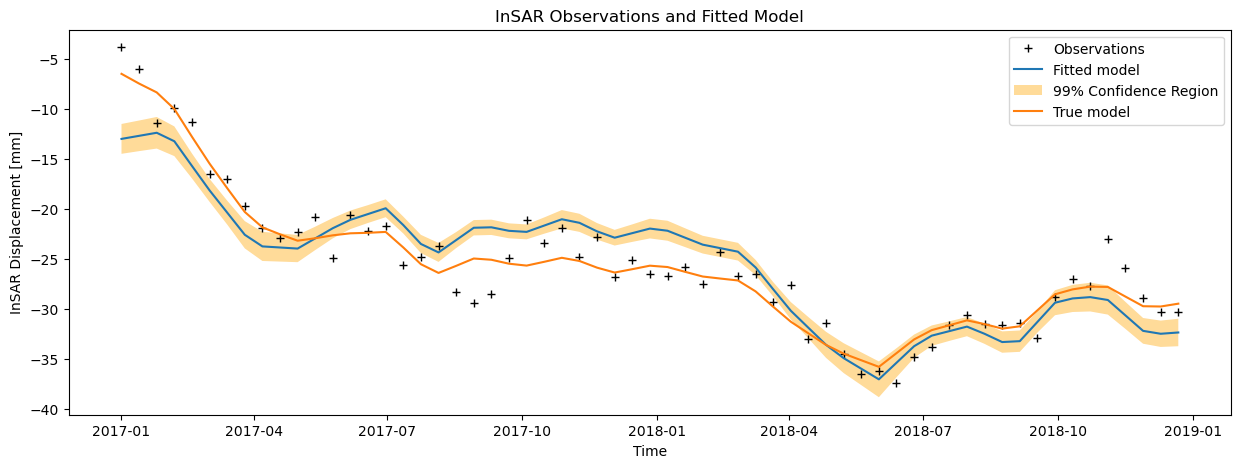

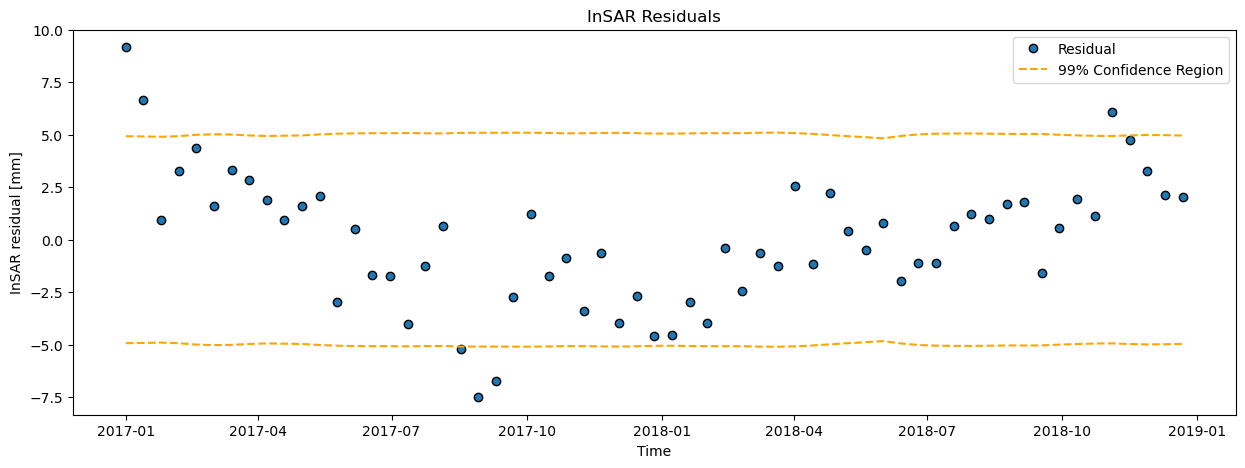

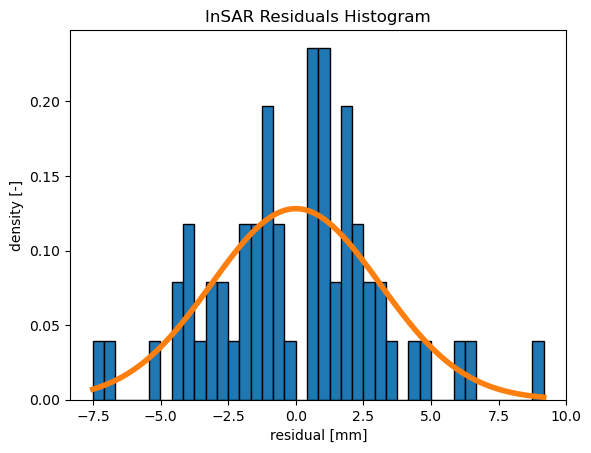

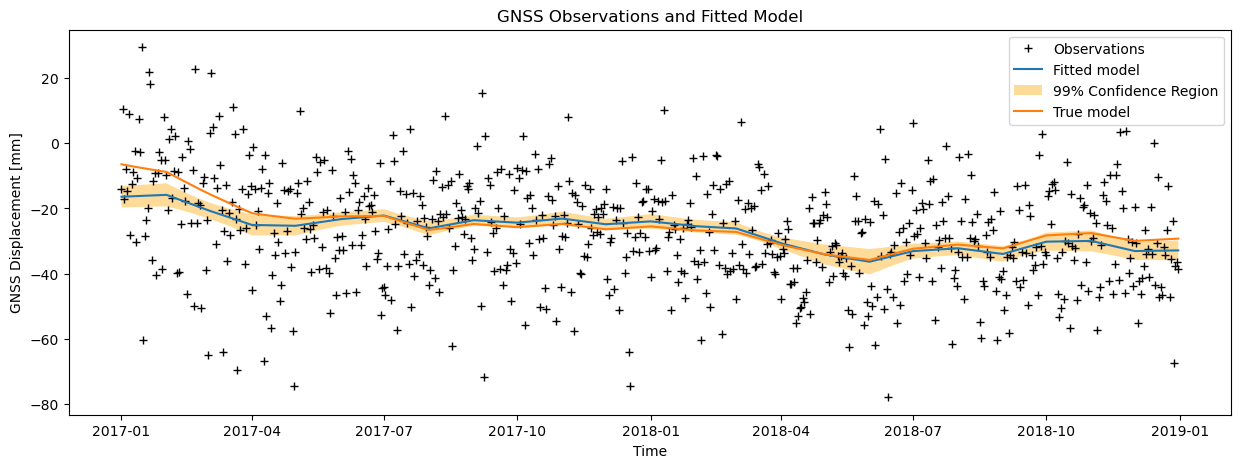

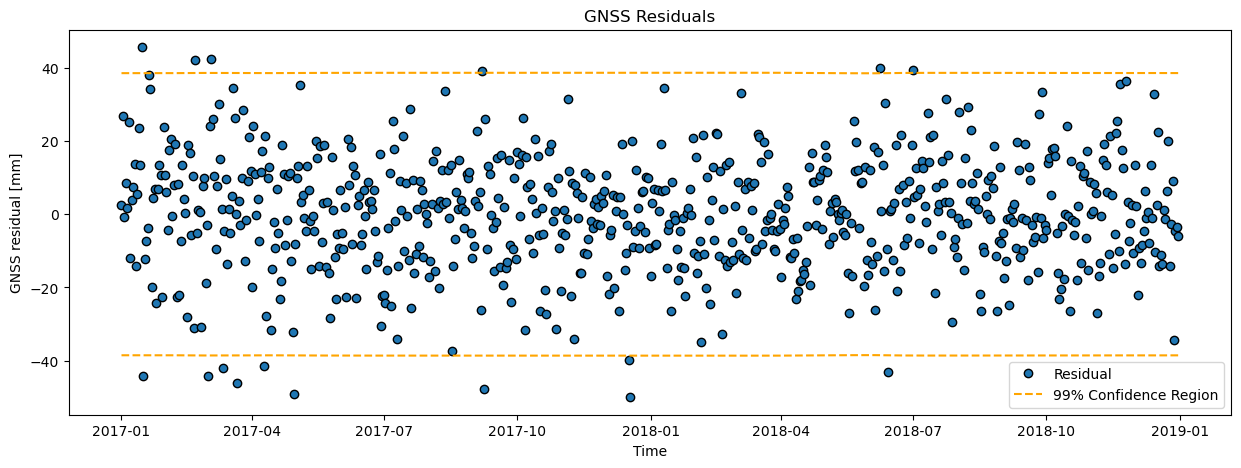

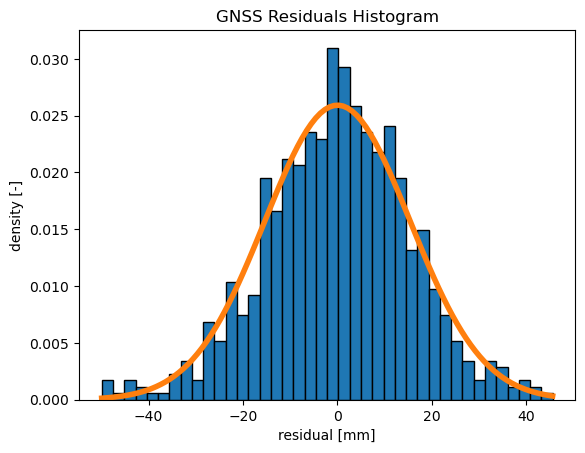

In [18]:
# this is the true model which was used to generate the data (Monte Carlo simulations)
k_true = 0.15
R_true = -22 
a_true = 180
d0_true = 10

disp_gnss  = (d0_true + R_true*(1 - np.exp(-days_gnss/a_true)) +
              k_true*GW_at_GNSS_times)
disp_insar = (d0_true + R_true*(1 - np.exp(-days_insar/a_true)) +
              k_true*GW_at_InSAR_times)

# Residuals and plots for InSAR incl. confidence bounds
yhat_insar = A_insar @ xhat_insar
ehat_insar_1 = plot_residual(dates_insar, y_insar, yhat_insar,
                              'InSAR', A_insar,
                              Sigma_Xhat_insar, Sigma_Y_insar,disp_insar)

# Residuals and plots for GNSS incl. confidence bounds
yhat_gnss = A_gnss @ xhat_gnss
ehat_gnss_1 = plot_residual(dates_gnss, y_gnss, yhat_gnss,
                             'GNSS', A_gnss, 
                             Sigma_Xhat_gnss, Sigma_Y_gnss, disp_gnss)


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6.2: </b>   
    
Answer the following questions:
<ol>
    <li>When you plot the residuals vs time, do you see any systematic effect? Give your interpretation for any discrepancy between observations and the model.</li>
    <li>What is the mean value of the residuals?</li>
    <li>What is the standard deviation of the residuals?</li>
    <li>What can you conclude when you compare the histogram of the data with the computed normal distribution? </li>
    <li>Did you use quantitative results in your answers?</li>
</ol>
</p>
</div>


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>  
    
<i>Note: here we plotted the true model as well, which you did not have.</i>
    
- The mean value and standard deviation of the InSAR residuals is 0.0 mm and 3.115 mm. 
- The mean value and standard deviation of the GNSS residuals is 0.0 mm and 15.393 mm.
    
First of all, for InSAR almost all residuals are within the 99% confidence bounds, indicating that the quality that we assumed for the observations was good. 
    
The fitted model seems to follow the observations relatively well, but does not capture the signal completely. This can especially be seen in the residual plot with the confidence bounds. You see that the residuals are not completely centered around zero but that we still see some 'signal' where the model underpredicts at the ends and overpredicts in the middle. Although the values are negative, we can see that the residual plot removes the trend described by the model and illustrates the "over" and "under" aspect quite clearly. 
    
Moreover, when reviewing the results for GNSS we see only a few outliers (residuals outside the 99% confidence bounds), which is logical given the 99% limit. Furthermore, the left side of the plot have many more observations that are below the confidence bound; this can also be seen in the left tail of the GNSS histogram, which is slightly asymmetric.
    
All of these observations indicate that the model is generally good, but misses some important characteristics in the data. Perhaps we should consider adding a bit of complexity (Part 2!).
    
</p>
</div>

## 7. Compare results between different datasets



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 7: </b>   
    
Compare the results you found for the InSAR observations and the GNSS observations in the questions above. Discuss the differences between the results. Be quantitative!
    

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 
    
Estimated parameters, hence fitted model, is different. 
    
Factors that have an impact are
    
- precision of the observations
    
- number of observations
    
- outliers in the GNSS data
    
    
Although the quality of the GNSS data is lower compared to InSAR (15 mm vs 2 mm), the precision of the estimated parameters is only a factor 2 worse. Here we see the effect of 'more' data points: the much lower precision of the observations is somewhat compensated by the much higher number of observations.

The GNSS data seems to have some outliers in the beginning and therefore the model fit is maybe not so good compared to InSAR. 

Also, when reviewing the residuals for both datasets, it seems that the model that we use is maybe too simple since we miss part of the signal. 
    


<div style="background-color:#ffa6a6; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"><p><b>Part 2:</b> from this cell and below, additional cells have been added to your notebook for you to complete the second part of Project 2.</p></div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p><strong>IMPORTANT</strong>
    
Depending on how your code is written, it is highly likely you will over-write variable names from Part 1, so be careful if you re-run cells above.</p></div>

## 8. Set-up non-linear functional model

In the model we fitted so far, we only considered a linear velocity and a dependency on the grounwater level. However, when a heavy construction is built on 'soft' soil layers, compaction of the upper layers will be observed. This compaction is relatively large in the beginning but decreases when time passes. We can approach the behavior with a simplified model, assuming an exponential decay. 

*Please note that this is very simplified model that does not necessarily rely on physics.* 

The new model is defined as
$$
d = d_0 + R \ \left(1-\exp\left(\frac{-t}{a}\right)\right) + k \ \textrm{GW},
$$
where $d$ is the displacement, $t$ is the time and $\textrm{GW}$ is the groundwater level. 

Therefore, the new model has 4 unknowns:
1. $d_0$, as the initial displacement at $t_0$;
2. $R$, which can be seen as the response of the soil layers to the extra weight of the road. Notice that when it is zero, there would be no compaction due to the extra loading;
3. $a$, as scaling parameter that represents the memory of the system;
4. $k$, as 'groundwater factor' that can be seen as the response of the layers due to changes in the groundwater level.

It can be seen that the model is non-linear. We will therefore use non-linear least-squares to solve for the unknown parameters. 



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8.1: </b>   
    
Choose initial values for the model parameters. Use the code and Markdown cells below to justify your decision. We suggest two possible approaches: a) use the forward model and make a plot to see if you can get it in the right order of magnitude, or b) make an inference about what the values might be using knowledge about each term in the model.
    
<i>Note: it may be useful at this point to define a function for your forward model to check the values. You will be able to re-use it in later Tasks as well.<i>
    
</p>
</div>

In [19]:
def forward_model(time, do_i, R_i, a_i, k_i, GW):
    """Compute the displacements based on our initial guess.
    """
    
    y_comp = do_i + R_i*(1-np.exp(-time/a_i))+k_i*GW
    
    return y_comp

In [20]:
# k_i = 
# R_i = 
# a_i = 
# do_i = 
# SOLUTION
k_i = 0.15
R_i = -25
a_i = 300
do_i = 9

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

- For $d_0$ and $k$ you could use the estimated values from the linear model
    
- For $R$: realize that it is the difference between displacement at start and end of the observation interval (look at plot with data).
    
- For $a$: you could plot an exponential function $R \left(1-\exp\left(\frac{-t}{a}\right)\right)$ and try different values of $a$ to see which one would fit well here.
    


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8.2: </b>   
    
Set up the Jacobian matrix for the non-linear least-squares. Using the initial values from Task 8.1, print the first 5 rows of the Jacobian matrix to confirm that your function works correctly (i.e., confirm that code runs and initial values give acceptable results).
    

</p>
</div>

In [21]:
def jacobian(time, do_i, R_i, a_i, k_i, GW):
    """Create the Jacobian matrix.
    
    The columns represent the linearized system of equations.
    """    
    
    # J_c1 = 
    # J_c2 = 
    # J_c3 = 
    # J_c4 = 
    
    # SOLUTION
    J_c1 = np.ones(len(time))
    J_c2 = 1 - np.exp(-time/a_i)
    J_c3 = -R_i*time/a_i**2 * np.exp(-time/a_i)
    J_c4 = np.ones(len(time))*GW

    
    J = np.column_stack((J_c1, J_c2, J_c3, J_c4))
    
    return J

In [22]:
J_insar = jacobian(days_insar, do_i, R_i, a_i, k_i, GW_at_InSAR_times)

print ('The first 5 rows of the Jacobian matrix for InSAR are:')
print (J_insar[0:5,:])

n_2 = np.shape(J_insar)[1]
print(f'\nThe number of unknowns is {n_2}')
print(f'The redundancy (InSAR) is {m_insar - n_2}')
print(f'The redundancy (GNSS) is {m_gnss - n_2}')

The first 5 rows of the Jacobian matrix for InSAR are:
[[ 1.000e+00  0.000e+00  0.000e+00 -1.097e+02]
 [ 1.000e+00  3.921e-02  3.203e-03 -1.067e+02]
 [ 1.000e+00  7.688e-02  6.154e-03 -1.038e+02]
 [ 1.000e+00  1.131e-01  8.869e-03 -1.065e+02]
 [ 1.000e+00  1.479e-01  1.136e-02 -1.173e+02]]

The number of unknowns is 4
The redundancy (InSAR) is 57
The redundancy (GNSS) is 726


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8.3:</b>   
    
What is the redundancy of the model with InSAR and GNSS, respectively?
</p>
</div>

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

- The number of unknowns is 4
- The redundancy (InSAR) is 57
- The redundancy (GNSS) is 726
    


## 9. Set-up Gauss-Newton iteration algorithm



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 9: </b>   
    
Set up a Gauss-Newton iteration algorithm (complete the code below). Choose the criterion to stop the iteration. 
Explain below how and why you define the stop-criterium. 

</p>
</div>

In [23]:
def nlsq_iteration(x0, day, y_obs, Sigma_Y, GW):
    """Use Gauss-Newton iteration to find non-linear parameters."""

    xnrm = 1000 # initialize stop criteria

    xhat_i = np.zeros((50, 4))
    xhat_i[0,:] = x0

    do_i = xhat_i[0,0]
    R_i = xhat_i[0,1]
    a_i = xhat_i[0,2]
    k_i = xhat_i[0,3]

    iter_ind = 0

    while xnrm >= 1e-12 and iter_ind < 49:

        # computed deformation yi based on 'estimates' 
        y_i = forward_model(day, do_i, R_i, a_i, k_i, GW)
        
        # dy = YOUR_CODE_HERE
        # SOLTUION
        dy = y_obs- y_i

        # J = YOUR_CODE_HERE
        # SOLTUION
        J = jacobian(day, do_i, R_i, a_i, k_i, GW)


        # d_xhat, Sigma_Xhat = YOUR_CODE_HERE
        # Hint: re-use your function BLUE, above
        # SOLUTION
        d_xhat, Sigma_Xhat = BLUE(J, dy, Sigma_Y)


        xhat_i[iter_ind+1,:] = xhat_i[iter_ind,:] + d_xhat.T

        do_i  = xhat_i[iter_ind+1,0]
        R_i  = xhat_i[iter_ind+1,1]
        a_i  = xhat_i[iter_ind+1,2]
        k_i = xhat_i[iter_ind+1,3]
        

        # xnrm = YOUR_CODE_HERE
        # SOLUTION
        xnrm = d_xhat.T @ np.linalg.inv(Sigma_Xhat) @ d_xhat

        # Update the iteration number
        iter_ind += 1

        if iter_ind==49:
            print("Number of iterations too large, check initial values.")

    xhat = xhat_i[iter_ind,:]
    xhat_i = xhat_i[0:iter_ind+1, :]
    return xhat, Sigma_Xhat, xhat_i, iter_ind, J


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>

We will use the 'weighted squared norm' of $\Delta \hat{\mathrm{x}}_{[i]}$, with the inverse covariance matrix $\Sigma_{\hat{X}}^{-1}$ as the weight matrix. In this way we account for different precisions of the parameters (high precision means we want the deviation to be smaller), as well as different order of magnitudes of the parameters.
    
</div>

## 10. Apply Gauss-Newton iteration



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 10.1: </b>   
    
Apply Gauss-Newton iteration on your model (run the code you completed above). 
    
For each unknown parameter, plot your estimates versus the iteration number (horizontal axis: iteration number, vertical axis: your estimate per iteration).

<i>For this Task, your output should include 8 plots at minimum (presenting additional values is also fine if it is relevant to your interpretation answers below).<i>
</p>
</div>

In [24]:
x0 = [do_i, R_i, a_i,k_i]

[xhat_insar, Sigma_Xhat_insar, xhat_i_insar, niter_insar, J_final_insar] = \
    nlsq_iteration(x0, days_insar, y_insar, Sigma_Y_insar, GW_at_InSAR_times)

[xhat_gnss, Sigma_Xhat_gnss, xhat_i_gnss, niter_gnss, J_final_gnss] = \
    nlsq_iteration(x0, days_gnss, y_gnss, Sigma_Y_gnss, GW_at_GNSS_times)

print('\n InSAR Reults for each iteration (#Interations =', niter_insar, ')')
print(xhat_i_insar)

print('\n GNSS Reults for each iteration (#Interations =', niter_gnss, ')')
print(xhat_i_gnss)


 InSAR Reults for each iteration (#Interations = 7 )
[[ 9.000e+00 -2.500e+01  3.000e+02  1.500e-01]
 [ 1.273e+01 -1.982e+01  1.407e+02  1.726e-01]
 [ 1.296e+01 -2.162e+01  1.768e+02  1.719e-01]
 [ 1.297e+01 -2.192e+01  1.793e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]]

 GNSS Reults for each iteration (#Interations = 10 )
[[ 9.000e+00 -2.500e+01  3.000e+02  1.500e-01]
 [ 3.747e+00 -1.777e+01  2.435e+02  1.425e-01]
 [ 3.895e+00 -1.812e+01  2.269e+02  1.418e-01]
 [ 3.939e+00 -1.815e+01  2.247e+02  1.416e-01]
 [ 3.945e+00 -1.815e+01  2.242e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01

In [25]:
# def plot_fit_iteration(xhat_i):
#     """Plot value of each parameter, each iteration."""
#     plt.figure(figsize = (15,4))
#     plt.subplots_adjust(top = 2)

#     plt.subplot(2,2,1)
#     YOUR_CODE_HERE
    
#     plt.subplot(2,2,2)
#     YOUR_CODE_HERE
    
#     plt.subplot(2,2,3)
#     YOUR_CODE_HERE
    
#     plt.subplot(2,2,4)
#     YOUR_CODE_HERE
    
def plot_fit_iteration(xhat_i):
    """Plot value of each parameter, each iteration."""
    plt.figure(figsize = (15,4))
    plt.subplots_adjust(top = 2)

    plt.subplot(2,2,1)
    plt.plot(xhat_i[:,0], linewidth=4)
    plt.title('Estimated offset')
    plt.ylabel('Offset [mm]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(2,2,2)
    plt.plot(xhat_i[:,1], linewidth=4)
    plt.title('Estimated R value')
    plt.ylabel('Estimated R value [mm]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(2,2,3)
    plt.plot(xhat_i[:,2], linewidth=4)
    plt.title('Estimated $a$ value')
    plt.ylabel('a value [days]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(2,2,4)
    plt.plot(xhat_i[:,3], linewidth=4)
    plt.title('Estimated GW factor')
    plt.ylabel('Estimated GW factor [-]')
    plt.xlabel('Number of iterations [-]')

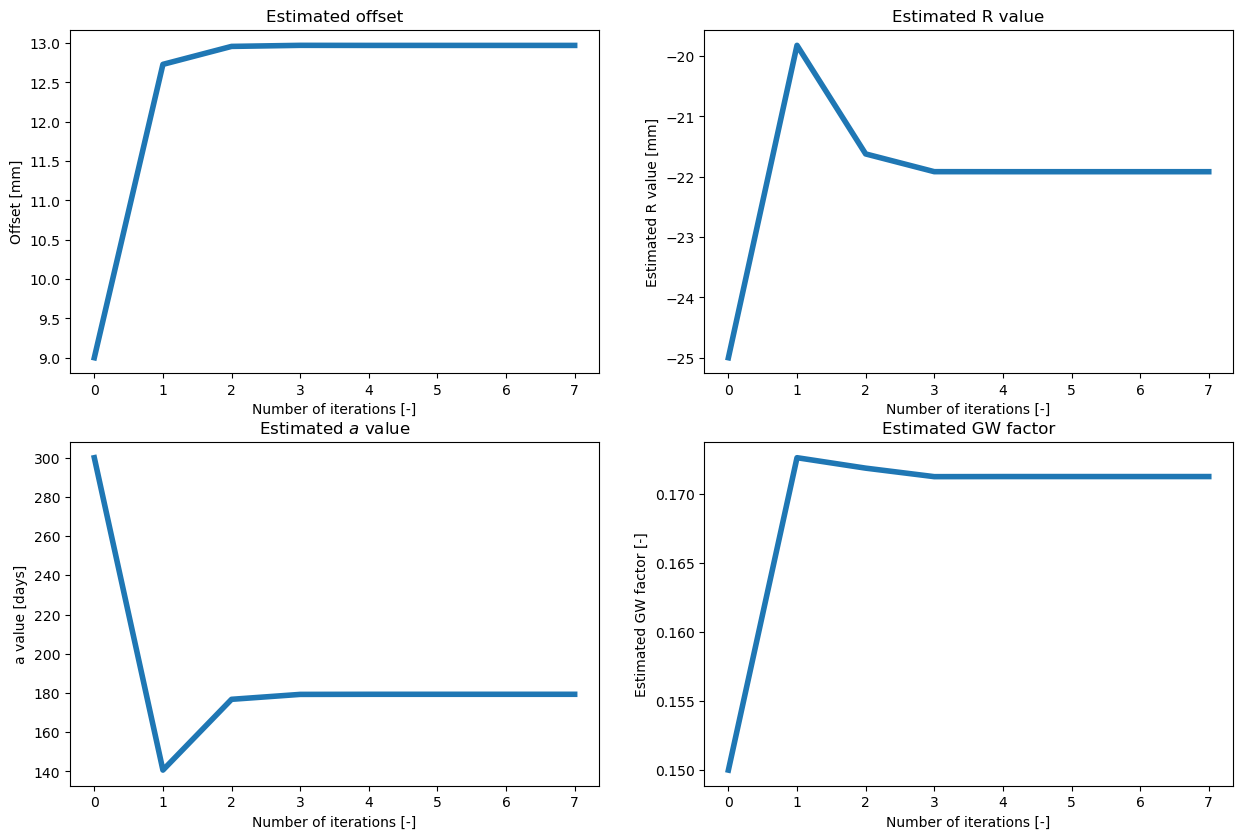

In [26]:
plot_fit_iteration(xhat_i_insar)

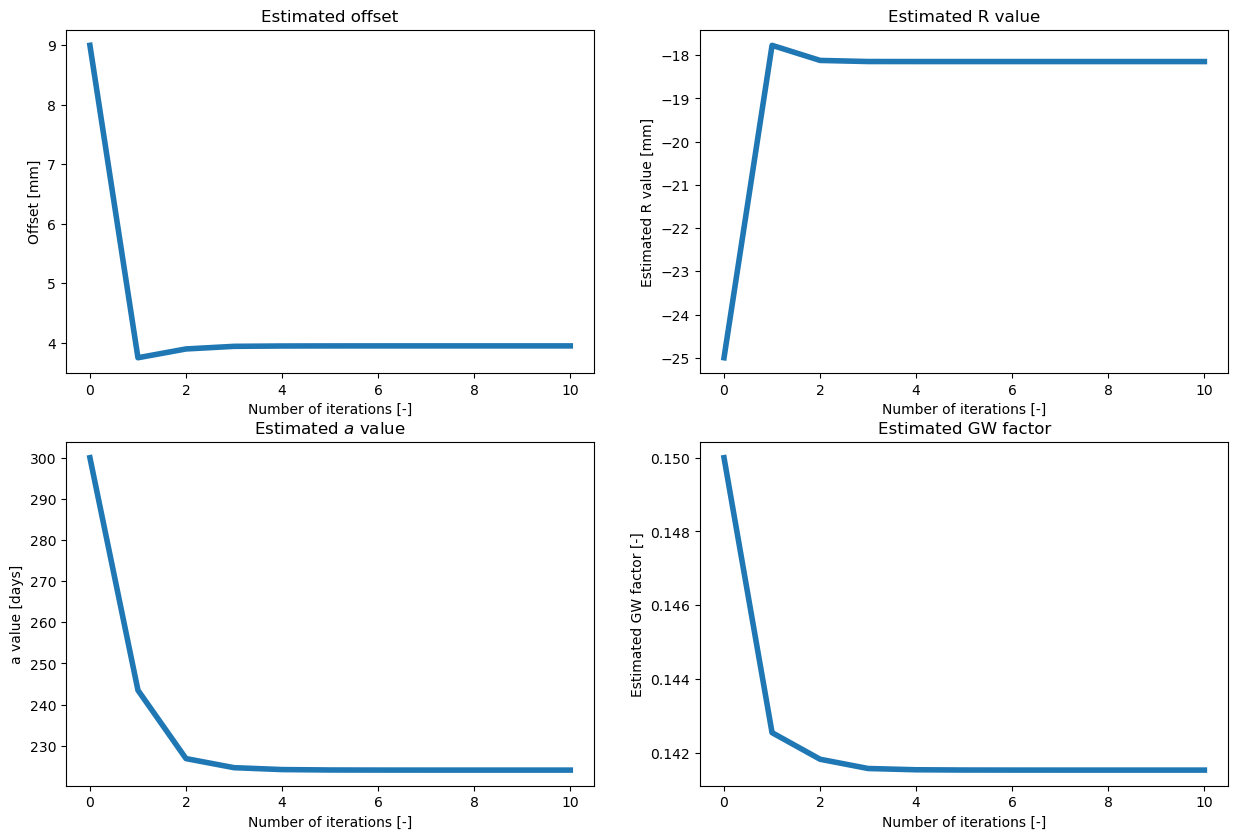

In [27]:
plot_fit_iteration(xhat_i_gnss)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 10.2: </b>   
    
- Does your iteration converge? If not, find out why and provide an explanation.

- After how many iterations does it converge? 
    
</p>
</div>

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>  

It converged! With InSAR only 5 iterations, with GNSS 8 iterations. This might be due to the difference in precision and number of observations.

    
</div>

## 11. Assess the precision of the estimates

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 11: </b>     
    
What is the quality of the final estimates? 
    
Provide the full covariance matrix of your estimates, and give an interpretation of the numbers in the covariance matrix.
    
</p>
</div>

In [28]:
def show_std(Sigma_Xhat, data_type):
    print ('The standard deviation for',
           data_type + '-offset is',
           np.round(np.sqrt(Sigma_Xhat[0,0]),2), 'mm')
    print ('The standard deviation for',
           data_type + '-R is',
           np.round(np.sqrt(Sigma_Xhat[1,1]),2), 'mm')
    print ('The standard deviation for',
           data_type + '-a is',
           np.round(np.sqrt(Sigma_Xhat[2,2]),2), 'days')
    print ('The standard deviation for',
           data_type + '-the ground water factor',
           np.round(np.sqrt(Sigma_Xhat[3,3]),3), '[-]')

In [29]:
print ('Covariance matrix of estimated parameters (InSAR):')
print (Sigma_Xhat_insar, '\n')
show_std(Sigma_Xhat_insar, 'InSAR')
print ('\nCovariance matrix of estimated parameters (GNSS):')
print (Sigma_Xhat_gnss, '\n')
show_std(Sigma_Xhat_gnss, 'GNSS')

Covariance matrix of estimated parameters (InSAR):
[[ 4.771e+00 -5.522e-01 -7.605e+00  3.183e-02]
 [-5.522e-01  1.017e+00  4.726e+00  2.657e-03]
 [-7.605e+00  4.726e+00  4.461e+02  6.328e-02]
 [ 3.183e-02  2.657e-03  6.328e-02  2.771e-04]] 

The standard deviation for InSAR-offset is 2.18 mm
The standard deviation for InSAR-R is 1.01 mm
The standard deviation for InSAR-a is 21.12 days
The standard deviation for InSAR-the ground water factor 0.017 [-]

Covariance matrix of estimated parameters (GNSS):
[[ 2.306e+01 -2.474e+00 -7.557e+01  1.514e-01]
 [-2.474e+00  4.674e+00  2.167e+00  6.718e-03]
 [-7.557e+01  2.167e+00  6.317e+03  4.459e-01]
 [ 1.514e-01  6.718e-03  4.459e-01  1.289e-03]] 

The standard deviation for GNSS-offset is 4.8 mm
The standard deviation for GNSS-R is 2.16 mm
The standard deviation for GNSS-a is 79.48 days
The standard deviation for GNSS-the ground water factor 0.036 [-]


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

The precision of the estimated offset $\hat{d}_0$ and $\hat{k}$ is approximately 2 mm and 0.02, respectively. With GNSS the of those parameters is a approximately a factor 2 worse due to the higher noise in the data. However, due to the high number of observations, the precision is still rather good. Note that the outliers do not have an impact on the precision, since the covariance matrix does not depend on the data (and outliers are non-random errors that are not accounted for in the covariance matrix).
Precision of parameters is good if compared to estimated values, except for $a$ and for GNSS also $R$ is less precise (std of 35 days, while estimated value is -15 days). This can only be explained by the higher noise in GNSS data, such that the exponential signal 'drowns' in the noise.

    
</div>

## 12. Present the estimation results



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 12.1:</b>   
    
Compute the modeled displacements ($\hat{\mathrm{y}}$), and corresponsing residuals ($\hat{\mathrm{\epsilon}}$). 
Visualize the results in two graphs and add the confidence bounds ($t$-versus-displacement and $t$-versus-residuals).

Also create a histogram of the residuals where you plot the normal distribution (which you can estimate from the histogram) as well and report the mean and sigma of the residuals. 
</p>
</div>

The mean value of the InSAR residuals is 0.0 mm
The standard deviation of the InSAR residuals is 1.852 mm


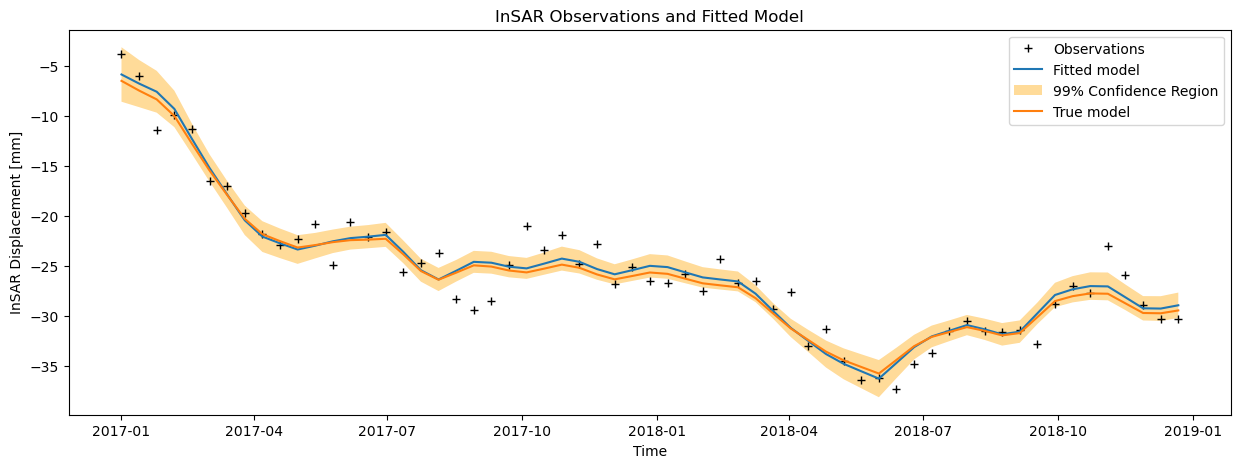

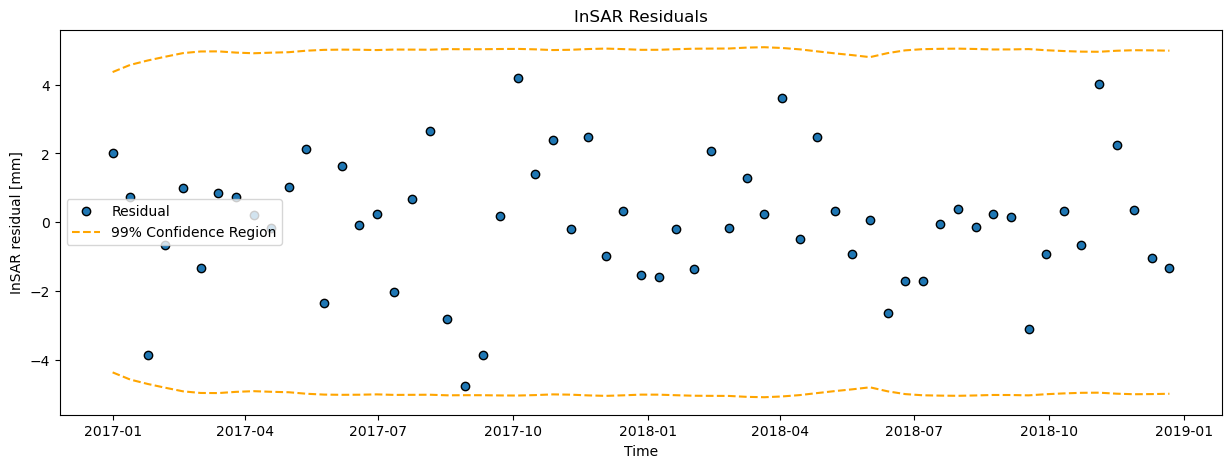

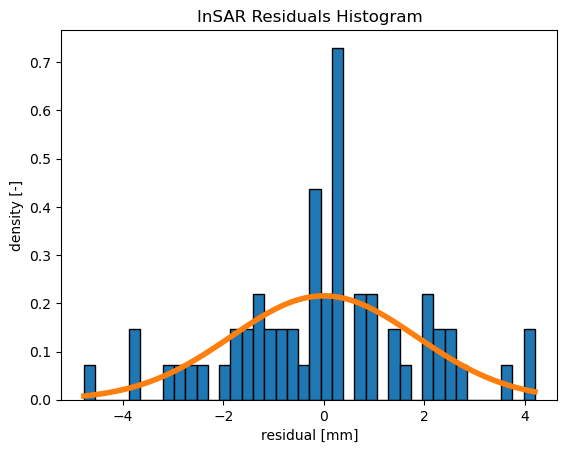

In [30]:
yhat_insar_2 = forward_model(days_insar, xhat_insar[0], xhat_insar[1], xhat_insar[2],\
                             xhat_insar[3], GW_at_InSAR_times)
ehat_insar_2 = plot_residual(dates_insar, y_insar, yhat_insar_2,
                              'InSAR', J_final_insar, Sigma_Xhat_insar,
                              Sigma_Y_insar, disp_insar)

The mean value of the GNSS residuals is 0.0 mm
The standard deviation of the GNSS residuals is 15.315 mm


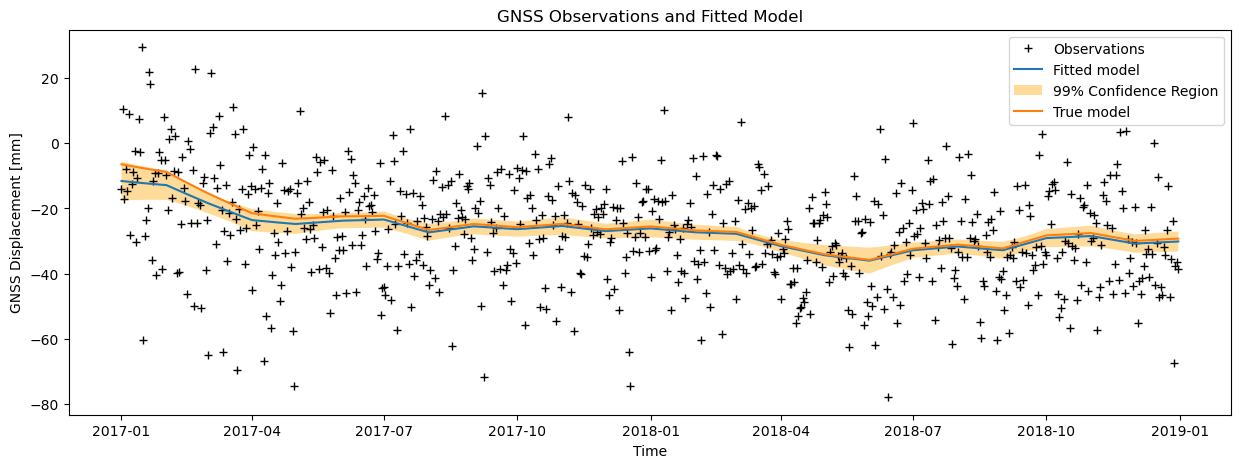

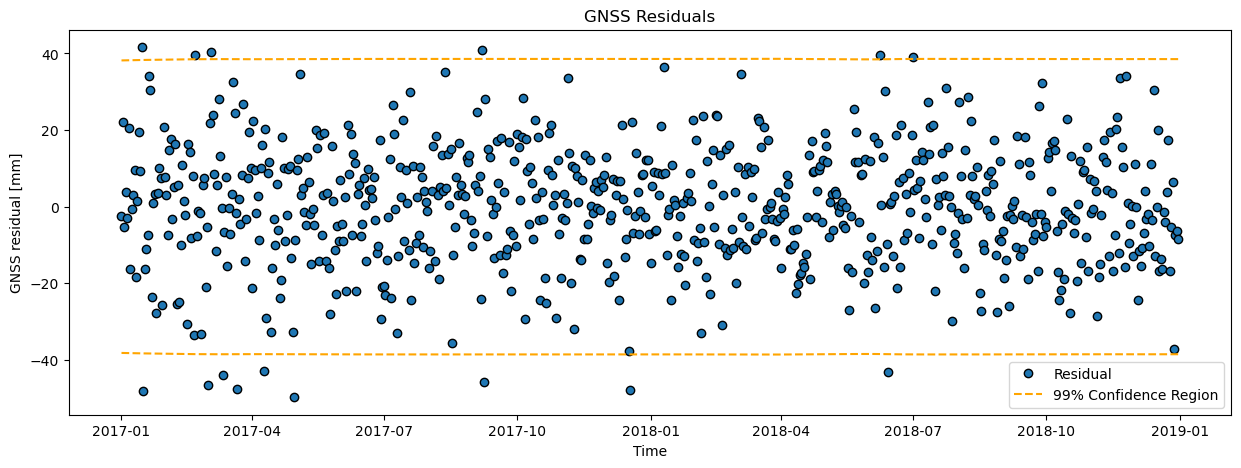

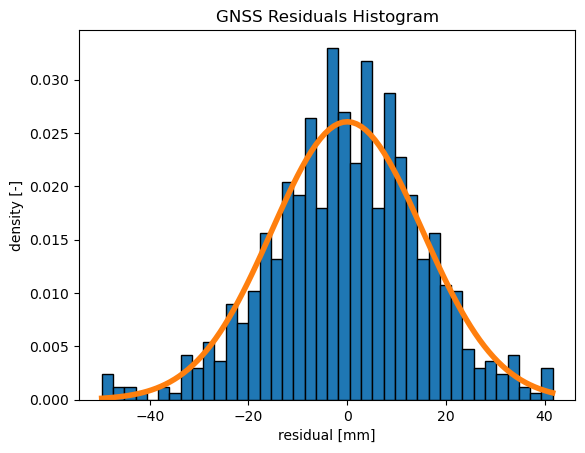

In [31]:
yhat_gnss_2 = forward_model(days_gnss, xhat_gnss[0], xhat_gnss[1], xhat_gnss[2],\
                             xhat_gnss[3], GW_at_GNSS_times)
ehat_gnss_2 = plot_residual(dates_gnss, y_gnss, yhat_gnss_2,
                             'GNSS', J_final_gnss, Sigma_Xhat_gnss,
                             Sigma_Y_gnss, disp_gnss)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 12.2:</b>   

Answer the following questions:
<ol>
    <li>Do you see any systematic effect?</li>
    <li>Give your interpretation for any discrepancy between observations and the model?</li>
    <li>What is the mean value of the residuals and what does this value tells you?</li>
    <li>And what is the empirical standard deviation of the residuals? Do you recognise this value?</li>
</ol>
</p>
</div>




**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 


The InSAR discrepancies look as expected, no systematic effects: the residuals have a zero-mean and standard deviation close to the precision of the observables. This tells us that the precision that we used for the observations corresponds to the true noise level. 
    
For GNSS there are still many residuals at the start of the observation period which are outside the confidence bounds, also resulting in slightly larger empirical standard deviation of the residuals. The effect of the outliers is also visible when comparing the fitted model with GNSS and InSAR : for GNSS it is pulled 'downwards'.
</div>

## 13. Strategies to improve?


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 13:</b>   

In order to get a better fit to the data (smaller residuals) for this case study, which of the following strategies could help? (elaborate on your answer)
<ol>
    <li>better observations?</li>
    <li>a more complicated geophysical model?</li>
    <li>better initial values?</li>
    <li>more observations?</li>
</ol>
</p>
</div>

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 
<ol>
    <li>better observations will help, and should result in smaller residuals.</li>
    <li>a more complicated geophysical model will help if it is able to capture the signal. However, since we don't see any systematic effects in the InSAR residuals, it is not expected that much gain can be expected. Including more parameters in the model will help to get smaller residuals, but is there still a geophysical explanation...?</li>
    <li>better initial values will not help, since solution converged to valid results.</li>
    <li>more observations generally helps, as long as they are not corrupted by outliers or systematic effects.</li>
</ol> 
</div>

## 14. Apply hypothesis test

In the assignment we used two different models:
* A linear model
* A model with linear and power components

Now we are going to test which model fits the data better. We will do this with the Generalized Likelihood Ratio (GLR) test for both the GNSS and InSAR observations





<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 14: </b>   

The critical value is computed with level of significance $\alpha=0.005$ the test statistics is computed in the code below.
    
Answer the following questions:
<ol>
    <li>What is the null hypothesis $H_0$ and alternative hypothesis $H_a$ in this test?</li>
    <li>How can you compute the test statistic? What is its distribution?</li>
</ol>
</p>
</div>


In [32]:
q = 1 #Degree of freedom
alpha = 0.005 

# Critical value
k = chi2.ppf(1 - alpha, df=q)
print(f'The critical value is {np.round(k, 3)}')

The critical value is 7.879


In [33]:
t1_insar = ehat_insar_1.T @ np.linalg.inv(Sigma_Y_insar) @ ehat_insar_1
t2_insar = ehat_insar_2.T @ np.linalg.inv(Sigma_Y_insar) @ ehat_insar_2
t_insar = t1_insar - t2_insar
print(f'The test statistic for InSAR data is {np.round(t_insar, 3)}')

The test statistic for InSAR data is 95.616


In [34]:
t1_gnss = ehat_gnss_1.T @ np.linalg.inv(Sigma_Y_gnss) @ ehat_gnss_1
t2_gnss = ehat_gnss_2.T @ np.linalg.inv(Sigma_Y_gnss) @ ehat_gnss_2
t_gnss = t1_gnss - t2_gnss
print(f'The test statistic for GNSS data is {np.round(t_gnss, 3)}')

The test statistic for GNSS data is 7.788


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>  
<ol>
    <li>The null hypothesis is that we assume that the linear model is correct, the alternative hypothesis that the model is incorrect.</li>
    <li>The test statistic is the difference of the weighted squared norms of residuals, and has a Chi-squared distribution with 1 degree of freedom, since there is 1 extra parameter in the alternative hypothesis model as compared to the null hypothesis.</li>
</ol>
</div>

## 15. Interpretation of test outcomes




<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 15: </b>   
    
Answer the following questions:
<ol>
    <li>What are the test statistic values for the two models (linear model and exponential model) for both the InSAR and the GNSS observations?</li>
    <li>What is to be concluded based on the individual test outcomes (i.e., for GNSS and InSAR)?</li>
    <li>Please compare the different test outcomes with InSAR and GNSS and discuss/explain them here.</li> 
</ol>
</p>
</div>


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>   
    
- For InSAR the the test statistic is 115.5 which is significantly larger than the critical value. Therefore the exponential model is accepted in favour of the linear one. 

- For GNSS the outcomes is different: test statistic is equal to 6.4, which is smaller than the critical value, resulting in acceptance of the null hypothesis (i.e., linear model). The reason is that the GNSS data is much noisier and contains many outliers, such that an exponential trend cannot be distinguished.
</div>

## 16. How to deal with 2 datasets?

Data acquisition and processing comes with a price. Note that in a real situation you would not look at a time series of only one point. For Sentinel-1 data you may have to pay, collecting GNSS data at different locations also costs money. 


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 16: </b>   
    How will you monitor the deformation if you have both GNSS and InSAR data at your disposal?
</p>
</div>


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>
    <li>Use the observations together (i.e., estimate the unknown parameters using the GNSS and InSAR observations at the same time, which would result in 791 observations). With BLUE we would of course apply proper weights, taking into account the different precisions.</li>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p> <b>Disclaimer:</b> the outliers in the GNSS data were added manually, and do not necessarily represent reality, which means that you cannot conclude from this assignment that InSAR is better than GNSS. Without the outliers, GNSS would have given you different results and then the larger noise would be compensated by the higher sampling rate.</p></div>

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.